# Model Tuning

## Imports and Load Data

In [60]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mape, rmse

In [2]:
eg_df = pd.read_csv('../data/evergreen-visits.csv', parse_dates=['Visit Date', 'Visit Time In', 'Visit Time Out'])
sb_df = pd.read_csv('../data/steamboat-visits.csv', parse_dates=['Visit Date', 'Visit Time In', 'Visit Time Out'])
# ch_df = pd.read_csv('../data/charleston-visits.csv', parse_dates=['Visit Date', 'Visit Time In', 'Visit Time Out'])

In [102]:
# group to visits per day
sb_visits_per_day = sb_df.groupby('Visit Date').count().rename({'Visit Time In': 'visits'}, axis=1).drop(['Visit Time Out', 'Visit Program'], axis=1).reset_index()
eg_visits_per_day = eg_df.groupby('Visit Date').count().rename({'Visit Time In': 'visits'}, axis=1).drop(['Visit Time Out', 'Visit Program'], axis=1).reset_index()

In [103]:
# prepare for prophet model
sb_visits_per_day = sb_visits_per_day.rename({'Visit Date': 'ds', 'visits':'y'}, axis=1)
eg_visits_per_day = eg_visits_per_day.rename({'Visit Date': 'ds', 'visits':'y'}, axis=1)

In [106]:
# extend Eg data with prior Sb data
df_to_concat = sb_visits_per_day.copy()
df_to_concat['ds'] = df_to_concat['ds'] + pd.DateOffset(years=4)

co_visits_per_day = pd.concat([eg_visits_per_day, df_to_concat[df_to_concat['ds'] < eg_visits_per_day['ds'].min()]]).sort_values(by='ds')

## Visualize First Year Data

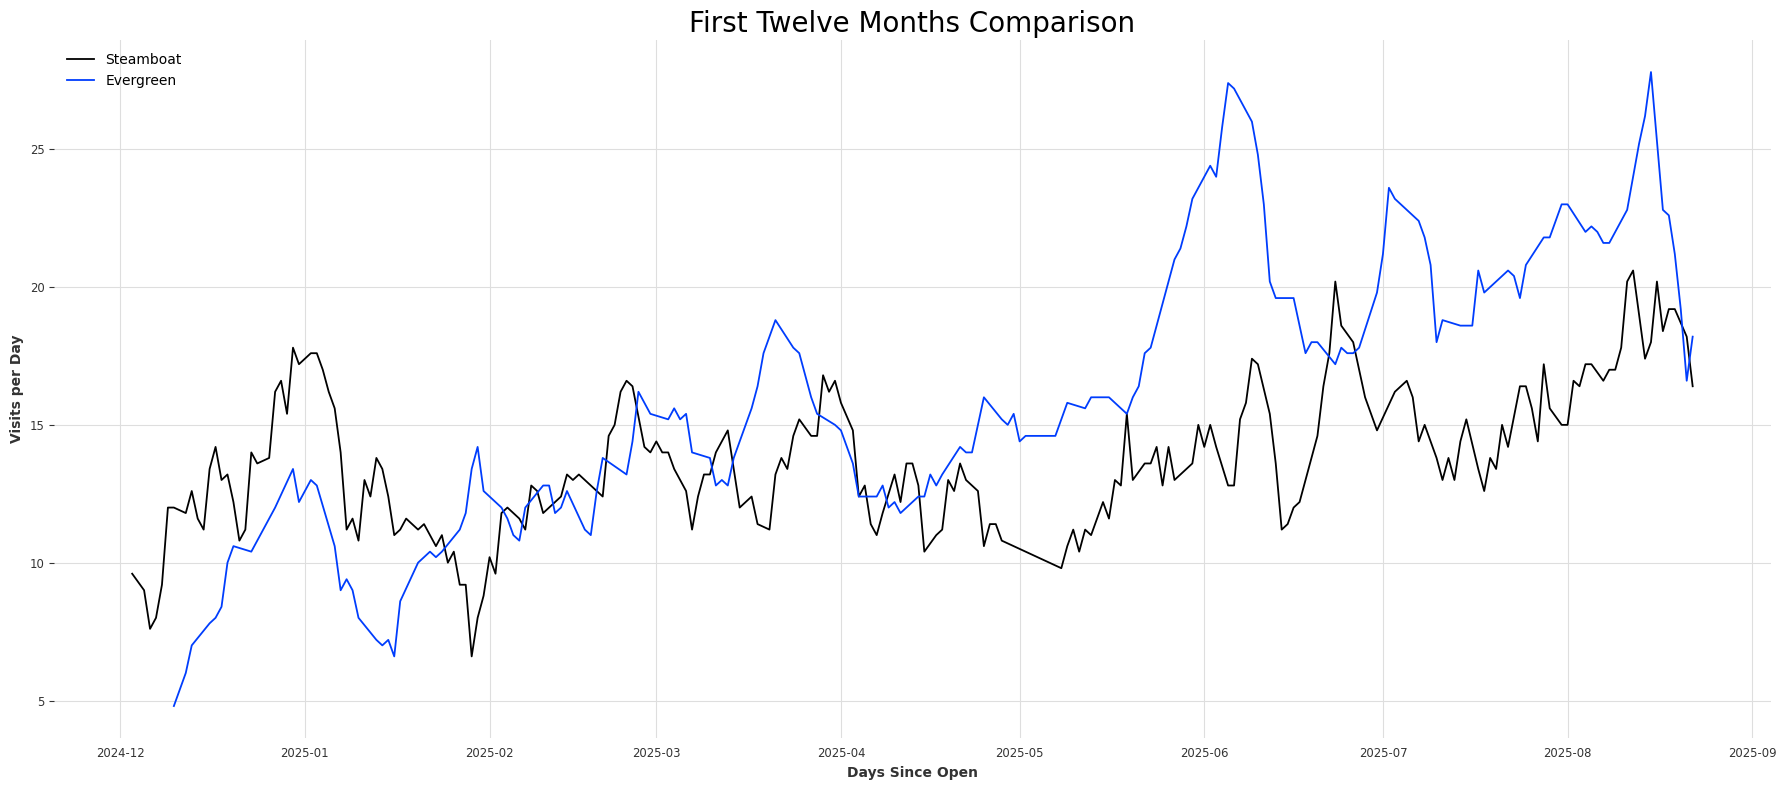

In [125]:
fig = plt.figure(figsize=(18,8))

sb_first_year = sb_visits_per_day.copy()
sb_first_year['adjusted_date'] = sb_first_year['ds'] + pd.DateOffset(years=8)
sb_first_year = sb_first_year.drop(columns='ds').set_index('adjusted_date')
sb_first_year['rolling_avg'] = sb_first_year['y'].rolling(window=5).mean()

# slice df to compare apples to apples
sb_df_to_compare = sb_first_year[eg_visits_per_day['ds'].min():eg_visits_per_day['ds'].max()]

plt.plot(sb_df_to_compare.index, sb_df_to_compare['rolling_avg'], label='Steamboat')
plt.plot(eg_visits_per_day['ds'], eg_visits_per_day['y'].rolling(window=5).mean(), label='Evergreen')

plt.legend()
plt.title('First Twelve Months Comparison', size=20)
plt.xlabel('Days Since Open')
plt.ylabel('Visits per Day')

plt.tight_layout()
plt.savefig('../images/first_year_comp.png')
plt.show();

## Evergreen Forecasting

In [ ]:
model = Prophet(growth='logistic')
model.add_country_holidays('US')
model.add_seasonality('yearly', period=365.25, fourier_order=10)
model.add_seasonality('monthly', period=30.5, fourier_order=5)
model.add_seasonality('weekly', period=7, fourier_order=5)

# The maximum possible visits per day based on regulations, size
co_visits_per_day['cap'] = 40 

model.fit(co_visits_per_day)

07:29:48 - cmdstanpy - INFO - Chain [1] start processing
07:29:48 - cmdstanpy - INFO - Chain [1] done processing


In [128]:
future = model.make_future_dataframe(periods=365)
future['cap'] = 40

fcst = model.predict(future)

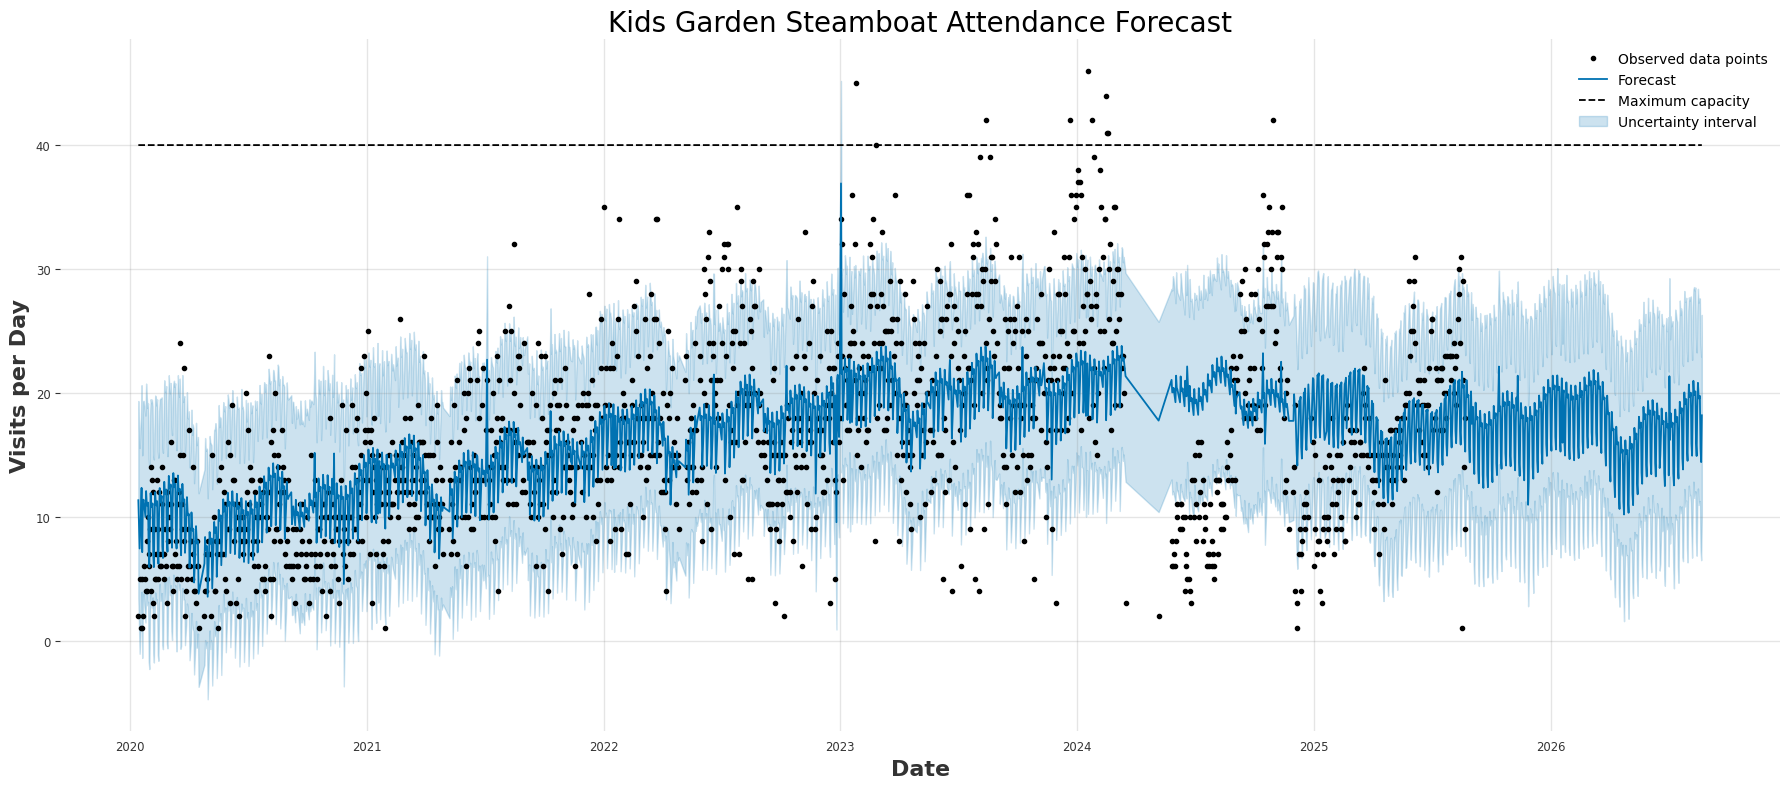

In [129]:
model.plot(fcst, figsize=(18,8))

plt.title('Kids Garden Steamboat Attendance Forecast', size=20)
plt.xlabel('Date', size=16)
plt.ylabel('Visits per Day', size=16)
plt.legend()
plt.tight_layout()
plt.savefig('../images/steamboat_forecast.png')
plt.show();

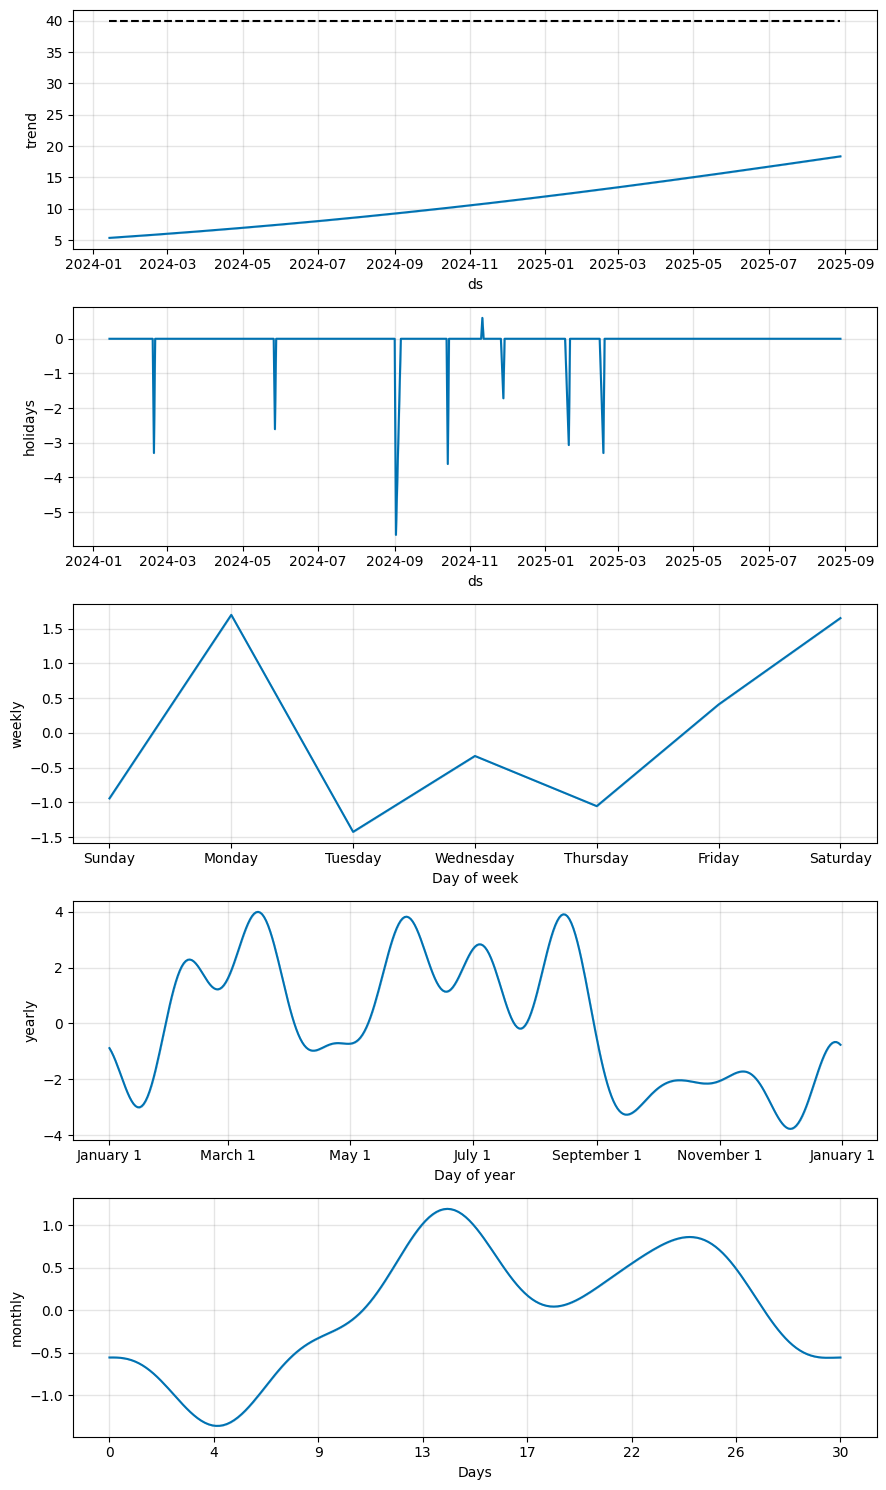

In [40]:
fig = model.plot_components(fcst)

## Model Evaluation

### Prophet

In [82]:
model = Prophet(growth='logistic')
model.add_country_holidays('US')
model.add_seasonality('yearly', period=365.25, fourier_order=5)
# model.add_seasonality('monthly', period=30.5, fourier_order=5)
# model.add_seasonality('weekly', period=7, fourier_order=3)

co_visits_per_day['cap'] = 40

model.fit(co_visits_per_day)

cv_df = cross_validation(model,
                         initial='1826.25 days',
                         period='365.25 days',
                         horizon='220.75 days')

perf_df = performance_metrics(cv_df)

07:52:00 - cmdstanpy - INFO - Chain [1] start processing
07:52:00 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/1 [00:00<?, ?it/s]07:52:00 - cmdstanpy - INFO - Chain [1] start processing
07:52:00 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


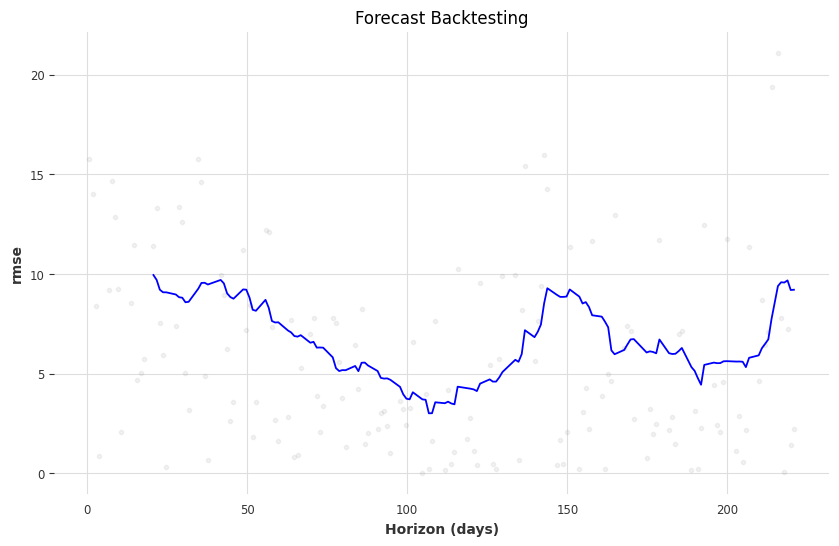

In [131]:
fig = plot_cross_validation_metric(cv_df, metric='rmse')

plt.title('Forecast Backtesting')
plt.savefig('../images/forecast_backtesting.png')

Off by about 10 visits per day on some days. Indicates we're still missing a seasonality component

### Darts

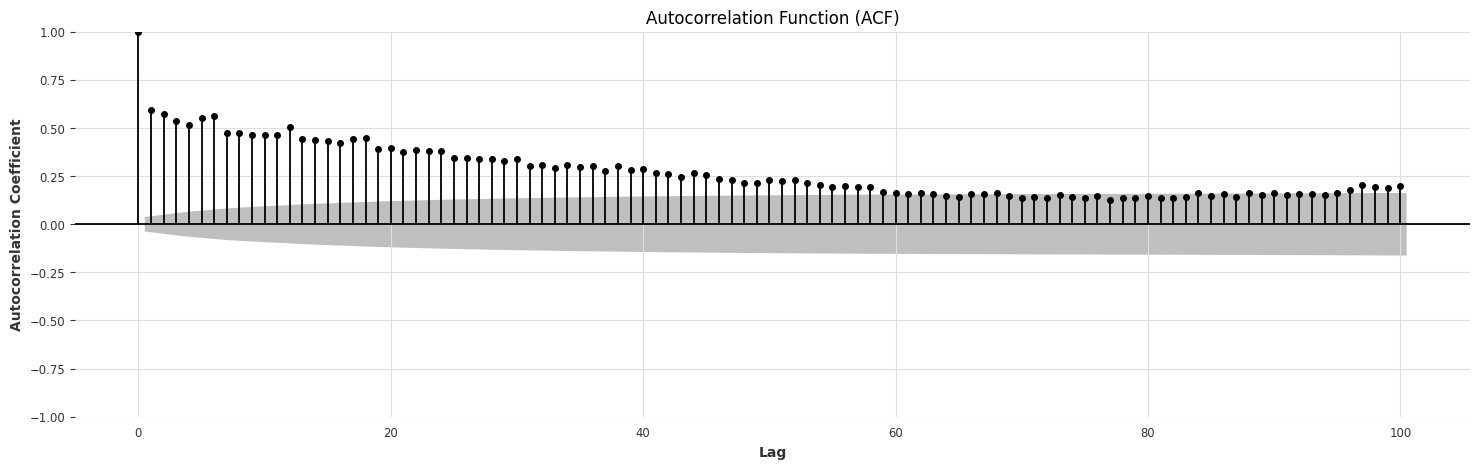

In [118]:
fig, ax = plt.subplots(figsize=(18, 5))
plot_acf(sb_visits_per_day['y'], ax=ax, lags=100, markersize=4)
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation Coefficient")
plt.show();

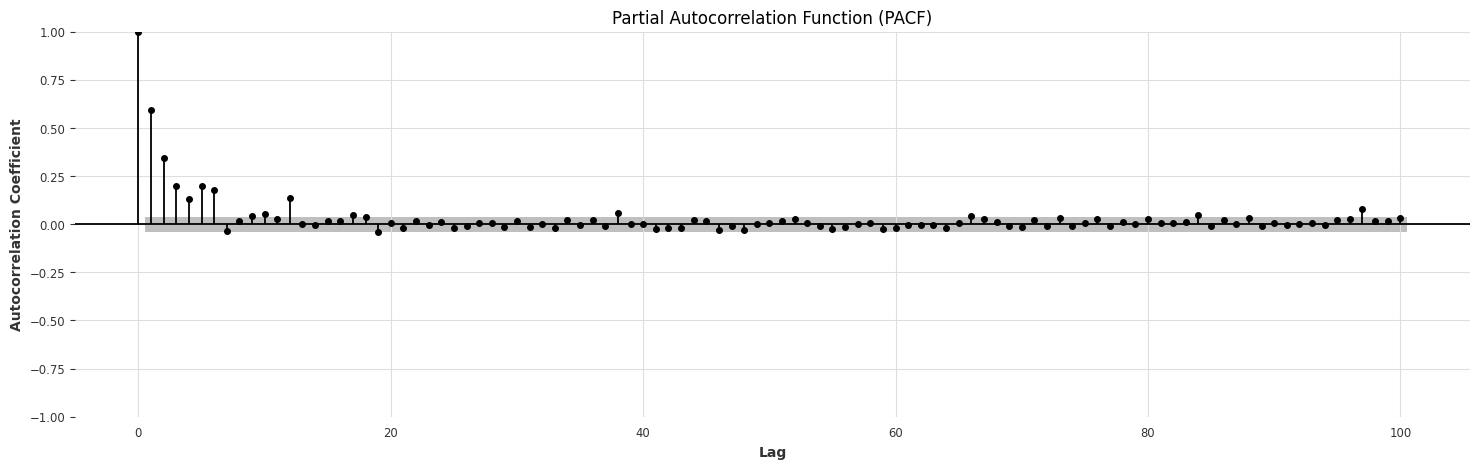

In [119]:
fig, ax = plt.subplots(figsize=(18, 5))
plot_pacf(sb_visits_per_day['y'], ax=ax, lags=100, markersize=4)
plt.title("Partial Autocorrelation Function (PACF)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation Coefficient")
plt.show();

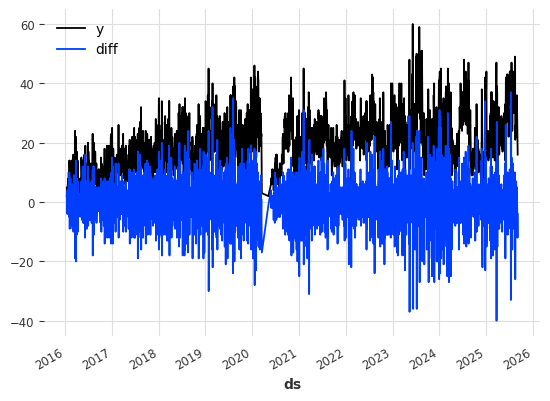

In [120]:
sb_visits_per_day['diff'] = sb_visits_per_day['y'].diff()
sb_visits_per_day.plot(x='ds');

In [ ]:
p = 7
d = 1
q = 64

In [123]:
ts = TimeSeries.from_dataframe(co_visits_per_day.set_index('ds'), fill_missing_dates=True, freq='D')

darts_model = ARIMA(p=7, d=1, q=8)

backtest_predictions = darts_model.backtest(
    ts,
    start=0.7,
    forecast_horizon=365,
    stride=1,
    metric=mape
)

backtest_predictions


c:\Users\dsigl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dsigl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dsigl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


np.float64(103.03817135628366)

103% error is a lot. There's likely another seasonal component here I'm not seeing